# Variabilité interannuelle : étude de l'oscillation nord Atlantique

Auteur : FERRY Frédéric (DESR/ENM/C3M) - novembre 2020

L'oscillation nord Altantique (NAO) se caractérise par une oscillation du champ moyen de pression réduite au niveau de la mer dans la région Atlantique nord. Elle a été découverte durant les années 1920 par Sir Gilbert Walker, qui avait découvert précédemment l’oscillation australe dans l'océan Pacifique et à laquelle est relié le phénomène El Niño (ENSO). Comme l’ENSO la NAO est un facteur climatique déterminant à l'échelle régionale car elle impacte la position et la trajectoire des perturbations qui touchent l'Europe de l'Ouest ainsi que les températures océaniques du bassin Atlantique nord.

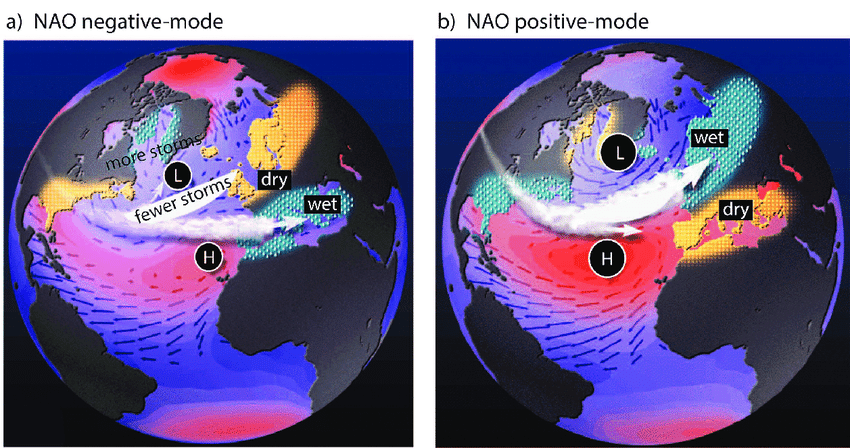


Régime NAO+ : anomalie positive de Pmer aux latitudes subtropicales et anomalie négative aux latitudes septentrionales. renforcement de la circulation zonale d’ouest sur le bassin Atlantique et l’Europe occidentale, décalage vers le Nord de la zone barocline.

Régime NAO- : anomalie négative s’étendant des Açores au bassin méditerranéen occidental, anomalie positive s’étirant du Groenland à la mer du Nord. Zone barocline moins marquée et plus au sud.

On s'intéressera ici à l'étude de la NAO et de sa variabilité interannuelle à partir de séries temporelles de pression réduite au niveau de la mer moyennées sur la période hivernale (DJFM) et sur le domaine Atlantique Nord. On comparera l'indice "station" de la NAO avec celui obtenu par une méthode d'analyse en composantes principales.

Concepts Python illustrés :

- Exploitation de fichiers netcdf (xarray)
- Calcul de climatologies et d'anomalies
- Tracé de cartes (cartopy)
- Etude de séries temporelles (pandas)
- Analyse en composantes principales (eofs)

# Bibliographie

http://www.umr-cnrm.fr/recyf/IMG/pdf/Cassou_la_meteorologie_04.pdf
https://www.encyclopedie-environnement.org/climat/variabilite-climatique-exemple-oscillation-nord-atlantique/

In [1]:
%matplotlib inline

import os

import numpy as np

import xarray as xr
from netCDF4 import Dataset

from cartopy import config
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from mpl_toolkits.axes_grid1 import ImageGrid

import pandas as pd
from pandas import Series
from pandas.tseries.offsets import MonthBegin

In [2]:
dir_data='./data/'
dir_figs='./figs/'
if not os.path.exists(dir_figs):
    os.makedirs(dir_figs)

# Partie 1 : étude de l'indice station NAO

L'indice NAO (https://climatedataguide.ucar.edu/climate-data/hurrell-north-atlantic-oscillation-nao-index-station-based) quantifie les variations de pression réduite au niveau de la mer en hiver entre les latitudes subtropicales et les latitudes subpolaires. Cet indice est calculé en faisant la différence des anomalies de Pmer entre Lisbonne (Portugal) et Stykkisholmur (Islande). Afin d'éviter que l'indice soit dominé par la plus grande variabilité de la station de Stykkisholmur, les anomalies sont normalisées i.e. pour chaque station, on soustrait la moyenne temporelle et on divise par l'écart type (période de référence 1864-1983).

Etude de l'indice station NAO : https://climatedataguide.ucar.edu/sites/default/files/nao_station_djfm.txt

In [3]:
nao_file=dir_data+'nao_station_djfm.txt'
df=pd.read_csv(nao_file, header=None, names = ['Year', 'Index'], delimiter=r"\s+")
df["Index"]
years=np.asarray(df["Year"])
nao_index=np.asarray(df["Index"])
print(years)
print(nao_index)

[1864 1865 1866 1867 1868 1869 1870 1871 1872 1873 1874 1875 1876 1877
 1878 1879 1880 1881 1882 1883 1884 1885 1886 1887 1888 1889 1890 1891
 1892 1893 1894 1895 1896 1897 1898 1899 1900 1901 1902 1903 1904 1905
 1906 1907 1908 1909 1910 1911 1912 1913 1914 1915 1916 1917 1918 1919
 1920 1921 1922 1923 1924 1925 1926 1927 1928 1929 1930 1931 1932 1933
 1934 1935 1936 1937 1938 1939 1940 1941 1942 1943 1944 1945 1946 1947
 1948 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961
 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975
 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989
 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003
 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017
 2018 2019]
[-1.02 -1.24  0.54 -1.38  2.81  1.7  -3.01 -1.01 -0.76 -0.5   2.32 -1.35
  0.21  0.05  1.46 -2.22  0.89 -3.8   3.87 -0.23  1.44 -0.89 -1.12  0.45
 -2.75 -0.01  1.78 -0.82 -2.02 -1.07  2.68 -3.97  1.12  1.09 

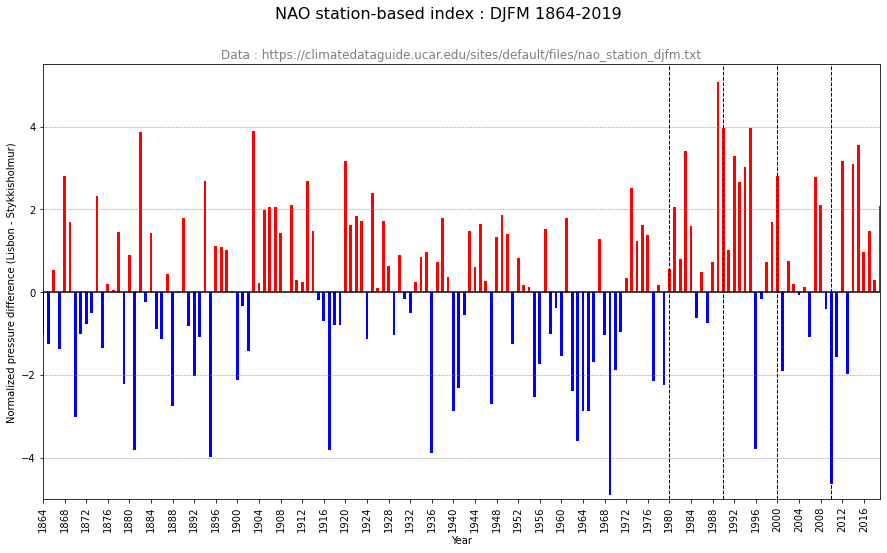

In [4]:
fig=plt.figure(figsize=(15, 8))

x0= df["Year"].iloc[0]
xf= df["Year"].iloc[-1]

fig.suptitle('NAO station-based index : DJFM '+str(x0)+'-'+str(xf), fontsize=16)
plt.title('Data : https://climatedataguide.ucar.edu/sites/default/files/nao_station_djfm.txt',
          fontsize=12, color='grey')
plt.xlabel('Year')
plt.ylabel('Normalized pressure difference (Lisbon - Stykkisholmur)')

plt.xlim(x0, xf)
plt.ylim(-5, 5.5)
xi = [i for i in range(x0, xf,4)]
plt.xticks(xi, range(x0, xf,4))
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)

colormat=np.where(nao_index>0, 'red','blue')
plt.bar(df["Year"], nao_index, width=0.5, color=colormat)
plt.axhline(0, color='k')
plt.axhline(2, color='grey', linestyle='--', linewidth=0.5)
plt.axhline(4, color='grey', linestyle='--', linewidth=0.5)
plt.axhline(-2, color='grey', linestyle='--', linewidth=0.5)
plt.axhline(-4, color='grey', linestyle='--', linewidth=0.5)
plt.axvline(1980, color='black', linestyle='--', linewidth=1)
plt.axvline(1990, color='black', linestyle='--', linewidth=1)
plt.axvline(2000, color='black', linestyle='--', linewidth=1)
plt.axvline(2010, color='black', linestyle='--', linewidth=1)

plt.show()

figname=dir_figs+'nao_index_'+str(x0)+'-'+str(xf)
fig.savefig(figname+'.png', bbox_inches='tight')

In [5]:
dates = pd.date_range('1864', '2019', freq='AS')
nao_index2 = Series(nao_index, index=dates)
print(nao_index2)

nao_index_smooth=nao_index2.rolling(window=5, center=True).mean()
print(nao_index_smooth)

1864-01-01   -1.02
1865-01-01   -1.24
1866-01-01    0.54
1867-01-01   -1.38
1868-01-01    2.81
              ... 
2015-01-01    3.56
2016-01-01    0.98
2017-01-01    1.47
2018-01-01    0.30
2019-01-01    2.09
Freq: AS-JAN, Length: 156, dtype: float64
1864-01-01      NaN
1865-01-01      NaN
1866-01-01   -0.058
1867-01-01    0.486
1868-01-01    0.132
              ...  
2015-01-01    1.428
2016-01-01    1.882
2017-01-01    1.680
2018-01-01      NaN
2019-01-01      NaN
Freq: AS-JAN, Length: 156, dtype: float64


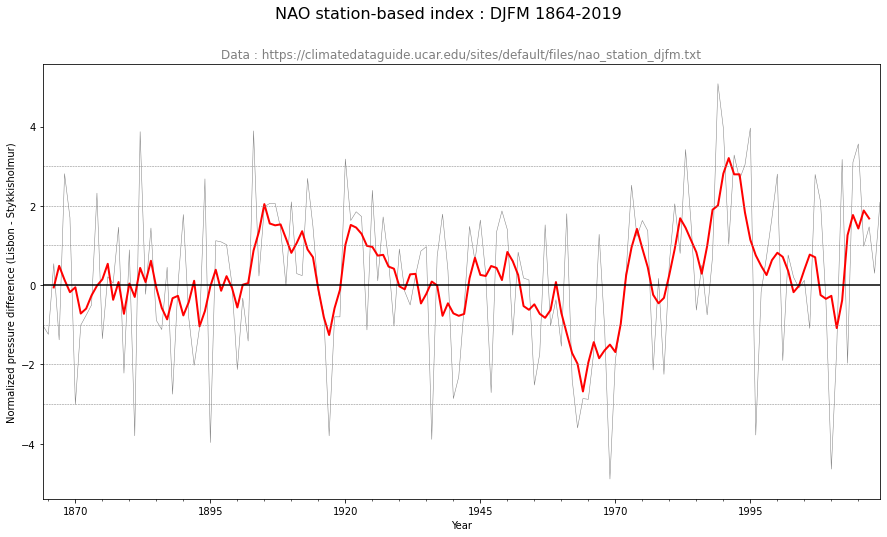

In [6]:
fig=plt.figure(figsize=(15, 8))
fig.suptitle('NAO station-based index : DJFM '+str(x0)+'-'+str(xf), fontsize=16)
plt.title('Data : https://climatedataguide.ucar.edu/sites/default/files/nao_station_djfm.txt' , fontsize=12, color='grey')
plt.xlabel('Year')
plt.ylabel('Normalized pressure difference (Lisbon - Stykkisholmur)')

ax = nao_index2.plot(color='grey', linewidth=0.5, alpha=1, label='NAO')
ax = nao_index_smooth.plot(color='red', linewidth=2, label='5-month RM NAO')

plt.axhline(0, color='k')
plt.axhline(1, color='grey', linestyle='--', linewidth=0.5)
plt.axhline(2, color='grey', linestyle='--', linewidth=0.5)
plt.axhline(3, color='grey', linestyle='--', linewidth=0.5)
plt.axhline(-1, color='grey', linestyle='--', linewidth=0.5)
plt.axhline(-2, color='grey', linestyle='--', linewidth=0.5)
plt.axhline(-3, color='grey', linestyle='--', linewidth=0.5)

plt.show()

figname=dir_figs+'nao_index_smooth_'+str(x0)+'-'+str(xf)
fig.savefig(figname+'.png', bbox_inches='tight')

# Partie 2 : étude des données spatialisées ERA5

Données de départ : climatologies mensuelles ERA5 de la pression réduite au niveau de la mer :
https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels-monthly-means?tab=form

Les données ont été préalablement traitées avec l'outil CDO (https://code.mpimet.mpg.de/projects/cdo/) afin de ne garder que des moyennes sur les mois DJFM pour le domaine Atlantique nord :
cdo sellonlatbox,-100,40,20,80 era5.mslp.mon.mean.nc era5.mslp.mon.mean.atl.nc
cdo timselmean,4,11,8 era5.mslp.mon.mean.atl.nc era5.mslp.djfm.mean.atl.nc

--> fichier era5.mslp.djfm.mean.atl.nc (moyennes DJFM de la Pmer sur l'Atlantique nord - période 1980-2021). Attention on supprimer la dernière valuer qui contient le mois de décembre 2021.

In [7]:
nc_file = dir_data+'era5.mslp.djfm.mean.atl.nc'

data    = xr.open_dataset(nc_file).sel(time=slice('1980-01-16','2021-01-16'))
data_clim = data.mean('time')
print(data)
print(data_clim)

lat  = data.latitude.values
lon  = data.longitude.values
time  = data.time.values

slp=data['msl']/100
slp_clim=data_clim['msl']/100

#--  Manage dates
time_str=[x for x in range(len(time))]
date_str=[x for x in range(len(time))]
for i in range(len(time)):
	time_str[i] = str(time[i])
	date_str[i] = time_str[i][0:10]

print(date_str)

year1 = int(date_str[0][0:4])
year2 = int(date_str[-1][0:4])

<xarray.Dataset>
Dimensions:    (time: 42, bnds: 2, longitude: 561, latitude: 241)
Coordinates:
  * time       (time) datetime64[ns] 1980-01-16T12:00:00 ... 2021-01-16T12:00:00
  * longitude  (longitude) float32 -100.0 -99.75 -99.5 ... 39.5 39.75 40.0
  * latitude   (latitude) float32 80.0 79.75 79.5 79.25 ... 20.5 20.25 20.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] ...
    msl        (time, latitude, longitude) float32 1.015e+05 ... 1.013e+05
Attributes:
    CDI:          Climate Data Interface version 1.9.9 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Sat Mar 05 10:34:47 2022: cdo timselmean,4,11,8 era5.mslp.m...
    CDO:          Climate Data Operators version 1.9.9 (https://mpimet.mpg.de...
<xarray.Dataset>
Dimensions:    (longitude: 561, latitude: 241)
Coordinates:
  * longitude  (longitude) float32 -100.0 -99.75 -99.5 ... 39.5 39.75 40.0
  * latitude   (latitude) float32 80.0 79.75 79.5 79.25 ... 20.5 

In [8]:
tot, clim, = xr.broadcast(data['msl'], data_clim['msl'])
slp_anom=(tot-clim)/100

In [9]:
projection = ccrs.Orthographic(central_longitude=-20, central_latitude=60)

def plot_background(ax):
    ax.coastlines()
    ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.5, color='gray', alpha=0.5, linestyle='-')
    return ax

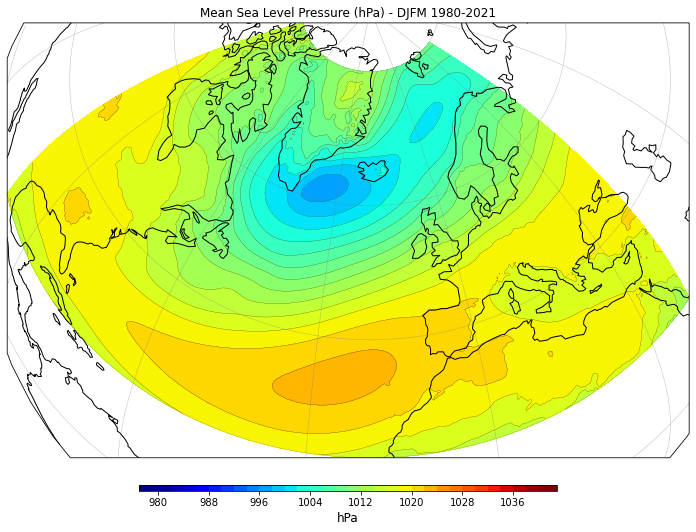

In [10]:
levels = np.arange(980,1042,2)

fig = plt.figure(figsize=(15., 10.))
ax = fig.add_subplot(1, 1, 1, projection=projection)
ax.set_title('Mean Sea Level Pressure (hPa) - DJFM '+ str(year1)+'-'+str(year2), loc='center')
plot_background(ax)
cf = ax.contourf(lon, lat, slp_clim, levels, cmap='jet', transform=ccrs.PlateCarree(), extend='both')
c = ax.contour(lon, lat, slp_clim, levels, colors='black', linewidths=0.2, transform=ccrs.PlateCarree())
cb = fig.colorbar(cf, orientation='horizontal', aspect=65, shrink=0.5, pad=0.05, extendrect='True')
cb.set_label('hPa', size='large')

plt.show()

figname=dir_figs+'mslp_DJFM_atl_'+ str(year1)+'-'+str(year2)
fig.savefig(figname+'.png', bbox_inches='tight')

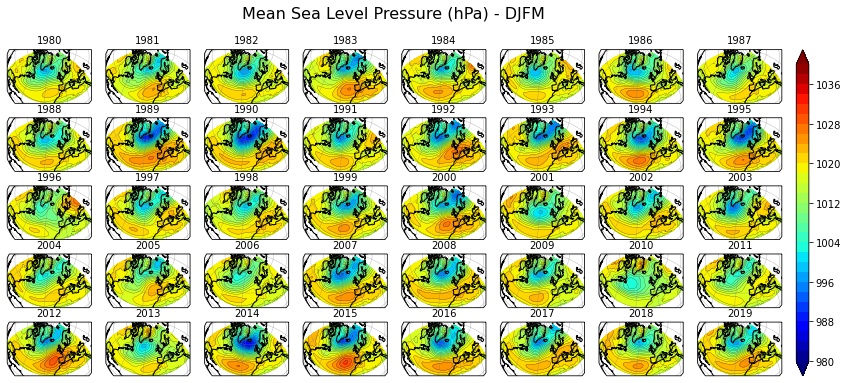

In [11]:
levels = np.arange(980,1042,2)

axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(16,6))
fig.suptitle('Mean Sea Level Pressure (hPa) - DJFM', fontsize=16)

axgr = AxesGrid(fig, 111, axes_class=axes_class,
       nrows_ncols=(5, 8),
       axes_pad=0.2,
       cbar_location='right',
       cbar_mode='single', # None/single/each
       cbar_pad=0.2,
       cbar_size='3%',
       label_mode='')  # note the empty label_mode
                   
for i, ax in enumerate(axgr):
    plot_background(ax)
    ax.set_title(date_str[i][0:4], fontsize=10)
    p1 = ax.contourf(lon, lat, slp[i,:,:], levels, transform=ccrs.PlateCarree(), cmap='jet', extend='both')
    p2 = ax.contour(lon, lat, slp[i,:,:], levels, colors='black', linewidths=0.2, transform=ccrs.PlateCarree())
    axgr.cbar_axes[i].colorbar(p1)

plt.show()

figname=dir_figs+'mslp_DJFM_atl_'+date_str[0]+'-'+date_str[-1]
fig.savefig(figname+'.png', bbox_inches='tight')

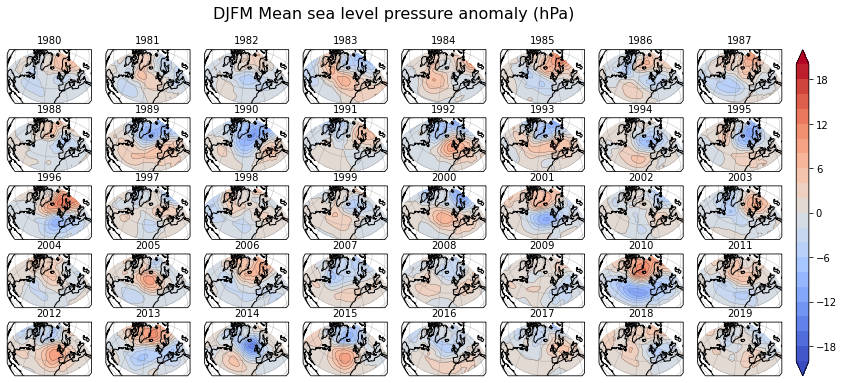

In [12]:
levels = np.arange(-20,22,2)

fig = plt.figure(figsize=(16,6))
fig.suptitle('DJFM Mean sea level pressure anomaly (hPa)', fontsize=16)

axgr = AxesGrid(fig, 111, axes_class=axes_class,
       nrows_ncols=(5, 8),
       axes_pad=0.2,
       cbar_location='right',
       cbar_mode='single', # None/single/each
       cbar_pad=0.2,
       cbar_size='3%',
       label_mode='')  # note the empty label_mode

for i, ax in enumerate(axgr):
    plot_background(ax)
    ax.set_title(date_str[i][0:4], fontsize=10)
    p1 = ax.contourf(lon, lat, slp_anom[i,:,:], levels, transform=ccrs.PlateCarree(), cmap='coolwarm', extend='both')
    p2 = ax.contour(lon, lat, slp_anom[i,:,:], levels, colors='black', linewidths=0.2, transform=ccrs.PlateCarree())
    axgr.cbar_axes[i].colorbar(p1)
   
plt.show()

figname=dir_figs+'mslp_anom_DJFM_atl_'+date_str[0]+'-'+date_str[-1]
fig.savefig(figname+'.png', bbox_inches='tight')

# Partie 3 : analyse en composantes principales des données ERA5

Méthode d'analyse en composantes principales (ACP, Empirical Orthogonal Function, EOF analysis) : méthode statistique permettant de simplifier des données spatio-temporelles en les décomposant structures spatiales de variabilité et en projections temporelles de ces structures. Les vecteurs propres (EOFs) sont des fonctions de base en terme de variance et correspodent à des structures spatiales. Les projections temporelles associées sont les composantes principales (PCs) et correspondent aux coefficients temporels des EOFs. On utilisera ici le package Python eofs : https://ajdawson.github.io/eofs/latest/

In [13]:
from eofs.standard import Eof

In [14]:
coslat = np.cos(np.deg2rad(lat)).clip(0., 1.)
wgts = np.sqrt(coslat)[..., np.newaxis]

In [15]:
slp_anom=np.array(slp_anom)
solver = Eof(slp_anom, weights=wgts, center=False)
#solver = Eof(slp_djfm_anom, weights=None, center=False) # ACP sans pondération

In [16]:
eigenvalues = solver.eigenvalues()
total_variance = solver.totalAnomalyVariance()
varfrac = solver.varianceFraction()
eofs = solver.eofsAsCovariance()
pcs = solver.pcs()
pcs_norm = solver.pcs(pcscaling=1)

print(eofs.shape)
print(pcs.shape)

print('******** Nombre de valeurs propres **********')
print(eigenvalues.size)
print('******** valeurs propres **********')
print(eigenvalues)
print('******** variance totale (somme des valeurs propres) **********')
print(total_variance)
print('******** Variance PC1 **********')
print(np.var(pcs[:,0]))
print('******** Variance PC2 **********')
print(np.var(pcs[:,1]))
print('******** Variance PC3 **********')
print(np.var(pcs[:,2]))
print('******** correlation PC1 PC2 **********')
cor_pc12=np.corrcoef(pcs[:,0], pcs[:,1])
print(round(cor_pc12[0,1],2))
print('******** pourcentage de variance EOF1 **********')
print(varfrac[0]*100)
print('******** pourcentage de variance EOF2 **********')
print(varfrac[1]*100)

(42, 241, 561)
(42, 42)
******** Nombre de valeurs propres **********
42
******** valeurs propres **********
[3.4250778e+05 1.0212031e+05 6.8687461e+04 4.7193055e+04 2.0472365e+04
 1.6505170e+04 1.3208290e+04 9.2675361e+03 5.8019541e+03 4.3722432e+03
 3.8978953e+03 2.9743130e+03 2.6566040e+03 1.9125748e+03 1.8391222e+03
 1.3576383e+03 1.1290293e+03 1.0512290e+03 8.5908887e+02 7.3622125e+02
 6.4826038e+02 6.0525348e+02 5.2425507e+02 4.2149524e+02 3.9296793e+02
 3.4810345e+02 3.0404849e+02 2.6641351e+02 2.4295193e+02 2.1393976e+02
 1.8818703e+02 1.5900452e+02 1.4089578e+02 1.3181349e+02 1.1866307e+02
 1.0242179e+02 9.3991737e+01 8.3784836e+01 7.2028389e+01 6.2007874e+01
 5.3523064e+01 7.3936483e-04]
******** variance totale (somme des valeurs propres) **********
653723.9
******** Variance PC1 **********
334352.84
******** Variance PC2 **********
99688.87
******** Variance PC3 **********
67052.04
******** correlation PC1 PC2 **********
0.0
******** pourcentage de variance EOF1 **********


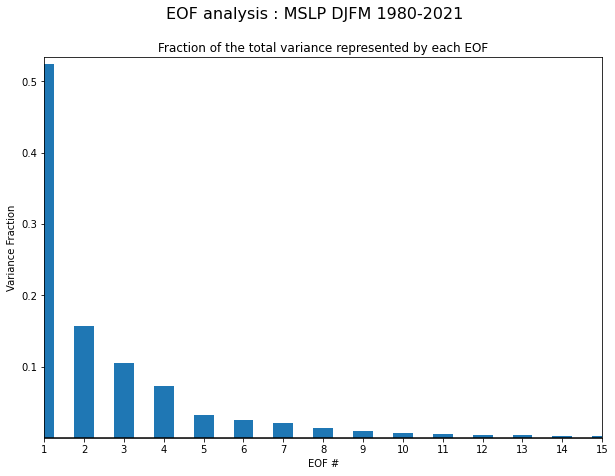

In [17]:
fig = plt.figure(figsize=(10, 7))
fig.suptitle('EOF analysis : MSLP DJFM '+ str(year1)+'-'+str(year2), fontsize=16)

eof_num = range(1, 16)
plt.bar(eof_num, varfrac[0:15], width=0.5)
plt.axhline(0, color='k')
plt.xticks(range(1, 16))
plt.title('Fraction of the total variance represented by each EOF')
plt.xlabel('EOF #')
plt.ylabel('Variance Fraction')
plt.xlim(1, 15)
plt.ylim(np.min(varfrac), np.max(varfrac)+0.01)
plt.show()

figname=dir_figs+'varfrac_mslp_djfm_atl'
fig.savefig(figname+'.png', bbox_inches='tight')

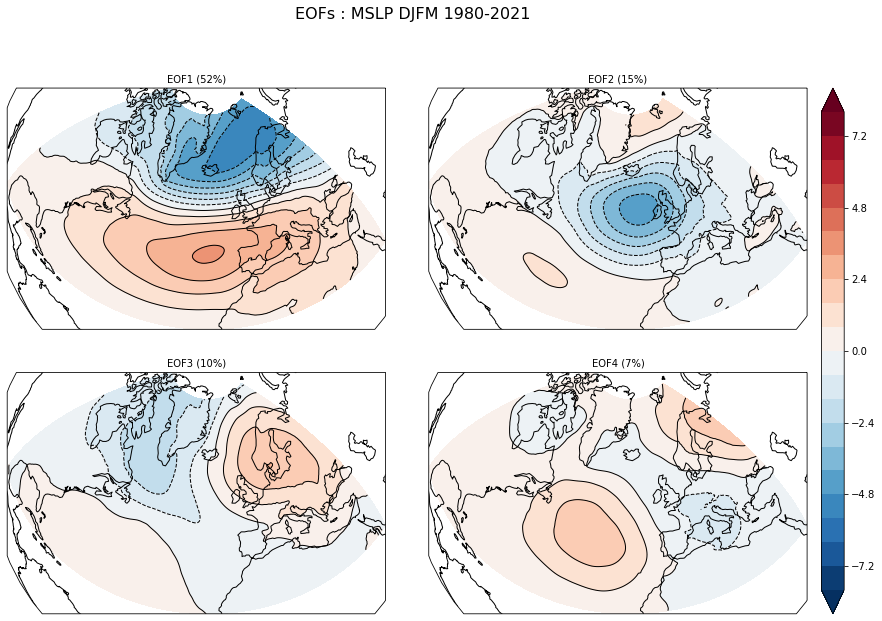

In [18]:
axes_class = (GeoAxes,
                  dict(map_projection=ccrs.Orthographic(central_longitude=-20, central_latitude=60)))
fig = plt.figure(figsize=(15,10))
fig.suptitle('EOFs : MSLP DJFM '+ str(year1)+'-'+str(year2), fontsize=16)

axgr = AxesGrid(fig, 111, axes_class=axes_class,
       nrows_ncols=(2, 2),
       axes_pad=0.6,
       cbar_location='right',
       cbar_mode='single', # None/single/each
       cbar_pad=0.2,
       cbar_size='3%',
       label_mode='')  # note the empty label_mode

clevs = np.linspace(-8, 8, 21)
                   
for i, ax in enumerate(axgr):
   ax.coastlines()
   ax.set_title('EOF'+str(i+1)+' ('+str(int(varfrac[i]*100))+'%)', fontsize=10, loc='center')
   cf = ax.contourf(lon, lat, eofs[i], clevs, transform=ccrs.PlateCarree(), cmap='RdBu_r', extend='both')
   c = ax.contour(lon, lat, eofs[i], levels=clevs, colors='black', linewidths=1, transform=ccrs.PlateCarree())
   axgr.cbar_axes[i].colorbar(cf)

plt.show()

figname=dir_figs+'eofs_mslp_djfm_atl'
fig.savefig(figname+'.png', bbox_inches='tight')

In [19]:
print(year1)
print(year2)
print(years)
print(years.shape)
print(pcs[:,0].shape)
years = np.arange(year1, year2+1)
xi = [i for i in range(year1, year2+1,5)]

def plot_pc(ax):
    plt.xlabel('Year')
    plt.axhline(0, color='k')
    plt.xlim(year1, year2+1)
    plt.xticks(xi, range(year1, year2+1,5))
    ax.axvline(1950, color='grey', linestyle='--', linewidth=0.5)
    ax.axvline(1960, color='grey', linestyle='--', linewidth=0.5)
    ax.axvline(1970, color='grey', linestyle='--', linewidth=0.5)
    ax.axvline(1980, color='grey', linestyle='--', linewidth=0.5)
    ax.axvline(1990, color='grey', linestyle='--', linewidth=0.5)
    ax.axvline(2000, color='grey', linestyle='--', linewidth=0.5)
    ax.axvline(2010, color='grey', linestyle='--', linewidth=0.5)
    plt.ylim(-1500, 1500)
    return ax

1980
2021
[1864 1865 1866 1867 1868 1869 1870 1871 1872 1873 1874 1875 1876 1877
 1878 1879 1880 1881 1882 1883 1884 1885 1886 1887 1888 1889 1890 1891
 1892 1893 1894 1895 1896 1897 1898 1899 1900 1901 1902 1903 1904 1905
 1906 1907 1908 1909 1910 1911 1912 1913 1914 1915 1916 1917 1918 1919
 1920 1921 1922 1923 1924 1925 1926 1927 1928 1929 1930 1931 1932 1933
 1934 1935 1936 1937 1938 1939 1940 1941 1942 1943 1944 1945 1946 1947
 1948 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961
 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975
 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989
 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003
 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017
 2018 2019]
(156,)
(42,)


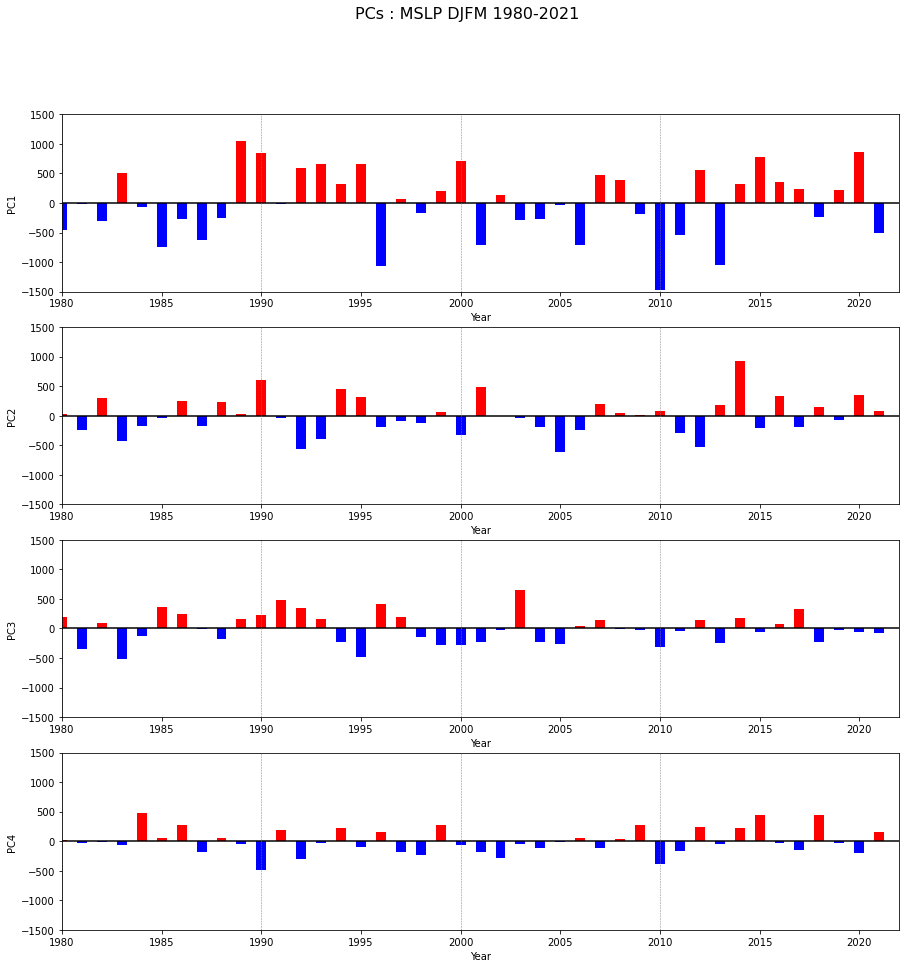

In [20]:
fig = plt.figure(figsize=(15,15))
fig.suptitle('PCs : MSLP DJFM '+ str(year1)+'-'+str(year2), fontsize=16)

ax = fig.add_subplot(411)
plt.ylabel('PC1')
plot_pc(ax)
colormat=np.where(pcs[:,0]>0, 'red','blue')
plt.bar(years, pcs[:,0], width=0.5, color=colormat)

ax = fig.add_subplot(412)
plt.ylabel('PC2')
plot_pc(ax)
colormat=np.where(pcs[:,1]>0, 'red','blue')
plt.bar(years, pcs[:,1], width=0.5, color=colormat)

ax = fig.add_subplot(413)
plt.ylabel('PC3')
plot_pc(ax)
colormat=np.where(pcs[:,2]>0, 'red','blue')
plt.bar(years, pcs[:,2], width=0.5, color=colormat)

ax = fig.add_subplot(414)
plt.ylabel('PC4')
plot_pc(ax)
colormat=np.where(pcs[:,3]>0, 'red','blue')
plt.bar(years, pcs[:,3], width=0.5, color=colormat)

plt.show()

figname=dir_figs+'pcs_mslp_djfm_atl'
fig.savefig(figname+'.png', bbox_inches='tight')

In [21]:
def plot_town(ax):
 ax.plot(-9.1, 38.7, marker='o', color='red', markersize=8,
         alpha=0.7, transform=ccrs.PlateCarree())
 ax.text(-9.1, 38.7, u'Lisbon',
             verticalalignment='center', horizontalalignment='right',
             transform=ccrs.PlateCarree()._as_mpl_transform(ax),
             bbox=dict(facecolor='sandybrown', alpha=0.5, boxstyle='round'))
 ax.plot(-22.5, 65.07, marker='o', color='red', markersize=8,
         alpha=0.7, transform=ccrs.PlateCarree())
 ax.text(-22.5, 65.07, u'Stykkisholmur',
             verticalalignment='center', horizontalalignment='right',
             transform=ccrs.PlateCarree()._as_mpl_transform(ax),
             bbox=dict(facecolor='sandybrown', alpha=0.5, boxstyle='round'))

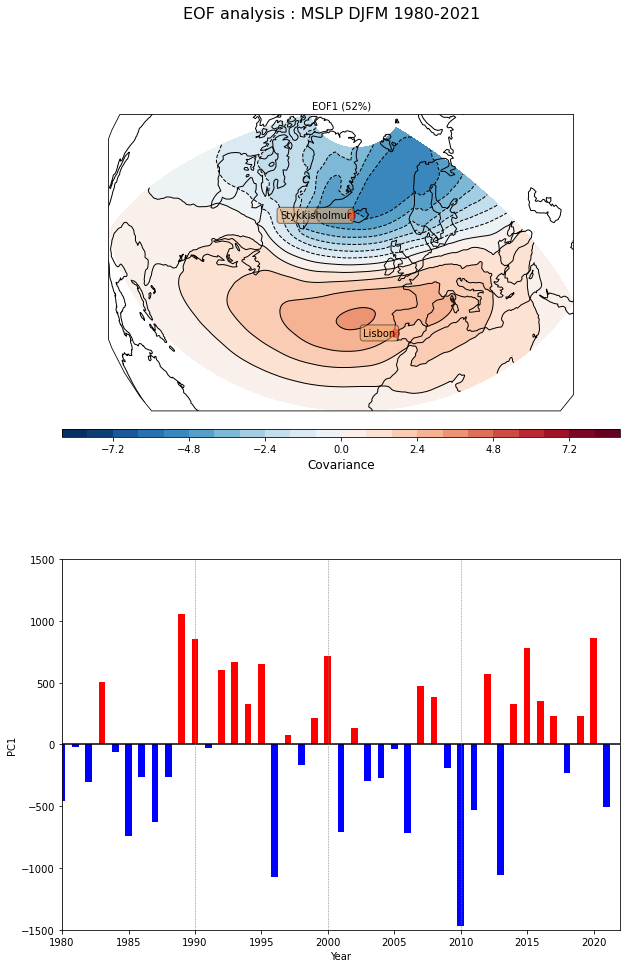

In [22]:
fig = plt.figure(figsize=(10, 15))
fig.suptitle('EOF analysis : MSLP DJFM '+ str(year1)+'-'+str(year2), fontsize=16)
ax = fig.add_subplot(211, projection=ccrs.Orthographic(central_longitude=-20, central_latitude=60))
plt.title('EOF1 ('+str(int(varfrac[0]*100))+'%)', fontsize=10, loc='center')
ax.coastlines()
plot_town(ax)
cf = ax.contourf(lon, lat, eofs[0], levels=clevs, transform=ccrs.PlateCarree(), cmap='RdBu_r', extend='both')
c = ax.contour(lon, lat, eofs[0], levels=clevs, colors='black', linewidths=1, transform=ccrs.PlateCarree())
cb = fig.colorbar(cf, orientation='horizontal', aspect=65, shrink=1, pad=0.05, extendrect='True')
cb.set_label('Covariance', fontsize=12)

ax = fig.add_subplot(212)
plt.ylabel('PC1')
plot_pc(ax)
colormat=np.where(pcs[:,0]>0, 'red','blue')
plt.bar(years, pcs[:,0], width=0.5, color=colormat)

plt.show()

figname=dir_figs+'eof1_pc1_mslp_djfm_atl'
fig.savefig(figname+'.png', bbox_inches='tight')

In [23]:
pc1=pcs_norm[:,0]
pc11=pc1[0:len(pc1)-2]
print(pc11)

years=np.asarray(df["Year"])
print(years)
id=np.where(years >= 1980.)
nao_year=years[id]
nao_index2=nao_index[id]
yr1=int(nao_year[0])
yr2=int(nao_year[-1])
print(yr1)
print(yr2)

cor=np.corrcoef(pc11, nao_index2)

[-0.7877174  -0.0284052  -0.5238316   0.8689046  -0.11034676 -1.2673509
 -0.44933635 -1.0753368  -0.44306087  1.8027205   1.4546813  -0.04206703
  1.0267864   1.1361139   0.5639576   1.1195855  -1.8321009   0.12677076
 -0.28597298  0.3594072   1.2172235  -1.2067887   0.23294544 -0.5025361
 -0.46582693 -0.06400678 -1.2191393   0.8066771   0.6576475  -0.32405844
 -2.5069766  -0.91250527  0.96923524 -1.7983428   0.5613599   1.3394254
  0.60567206  0.3951697  -0.39269972  0.38754806]
[1864 1865 1866 1867 1868 1869 1870 1871 1872 1873 1874 1875 1876 1877
 1878 1879 1880 1881 1882 1883 1884 1885 1886 1887 1888 1889 1890 1891
 1892 1893 1894 1895 1896 1897 1898 1899 1900 1901 1902 1903 1904 1905
 1906 1907 1908 1909 1910 1911 1912 1913 1914 1915 1916 1917 1918 1919
 1920 1921 1922 1923 1924 1925 1926 1927 1928 1929 1930 1931 1932 1933
 1934 1935 1936 1937 1938 1939 1940 1941 1942 1943 1944 1945 1946 1947
 1948 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961
 1962 1963 1964 19

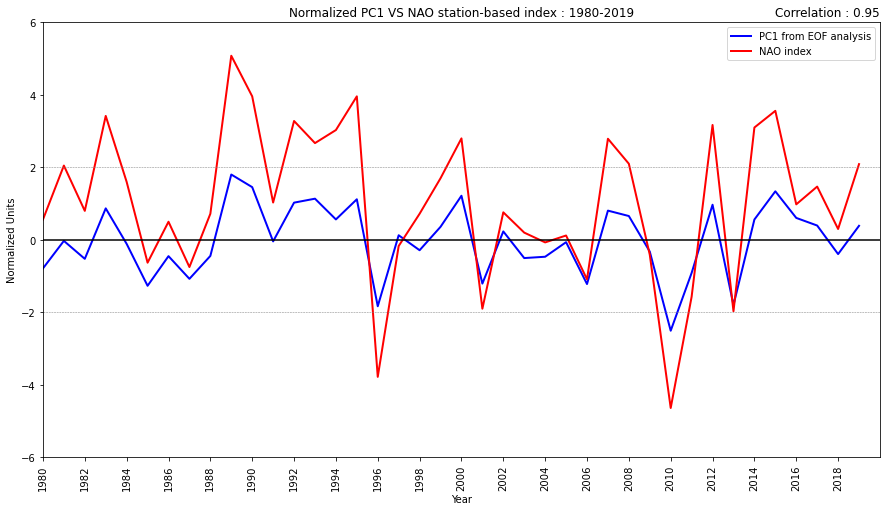

In [24]:
fig = plt.figure(figsize=(15., 8.))
plt.title('Normalized PC1 VS NAO station-based index : '+str(yr1)+'-'+str(yr2), loc='center')
plt.title('Correlation : '+str(round(cor[0,1],2)), loc='right')

plt.xlabel('Year')
plt.ylabel('Normalized Units')
yrs = range(yr1, yr2+1)
xi = [i for i in range(yr1, yr2+1,2)]
plt.plot(yrs, pc11, color='b', linewidth=2, label='PC1 from EOF analysis')
plt.plot(yrs, nao_index2, color='r', linewidth=2, label='NAO index')
plt.axhline(0, color='k')
plt.axhline(2, color='grey', linestyle='--', linewidth=0.5)
plt.axhline(-2, color='grey', linestyle='--', linewidth=0.5)
plt.xlim(yr1, yr2+1)
plt.xticks(xi, range(yr1, yr2+1,2))
plt.ylim(-6, 6)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.legend()

plt.show()

figname=dir_figs+'nao_index_vs_pc1'
fig.savefig(figname+'.png', bbox_inches='tight')

In [25]:
reconstruction1 = solver.reconstructedField(1)
reconstruction2 = solver.reconstructedField(2)
reconstruction3 = solver.reconstructedField(3)
reconstruction4 = solver.reconstructedField(4)
reconstruction5 = solver.reconstructedField(5)
reconstruction6 = solver.reconstructedField(6)
reconstruction7 = solver.reconstructedField(7)
reconstruction8 = solver.reconstructedField(8)
reconstruction9 = solver.reconstructedField(9)
print(reconstruction1.shape)

(42, 241, 561)


In [26]:
year='2015-01-16'
iyear = list(date_str).index(year)

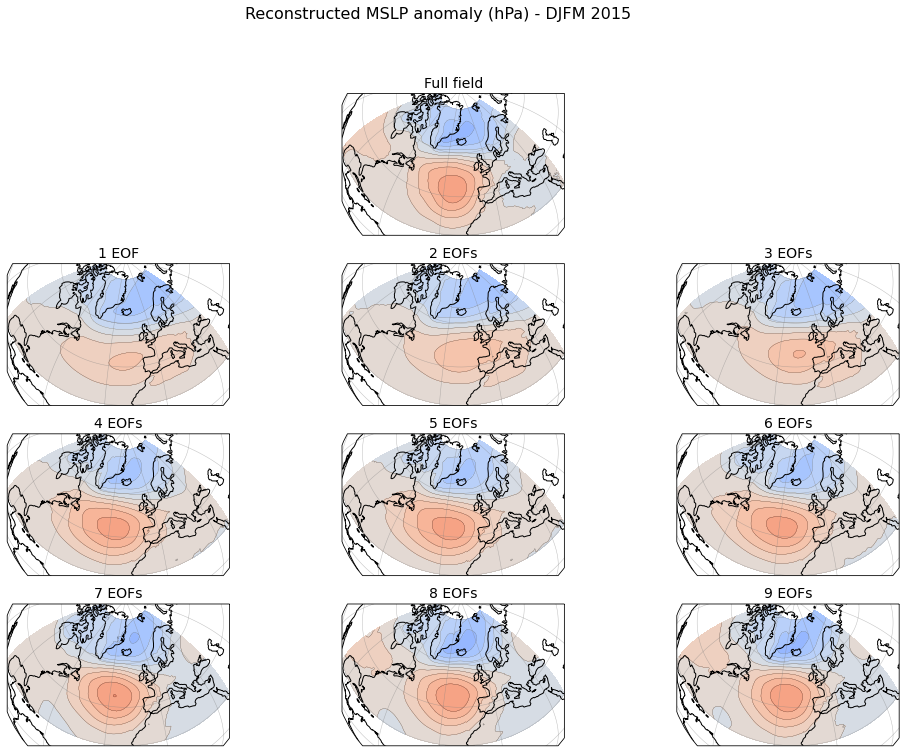

In [27]:
levels = np.arange(-20,22,2)

fig = plt.figure(figsize=(17,12))
fig.suptitle('Reconstructed MSLP anomaly (hPa) - DJFM '+ str(year)[0:4], fontsize=16)

ax = fig.add_subplot(4,3,2, projection=projection)
plot_background(ax)
ax.set_title('Full field', fontsize=14)
p1 = ax.contourf(lon, lat, slp_anom[iyear,:,:], levels, transform=ccrs.PlateCarree(), cmap='coolwarm', extend='both')
p2 = ax.contour(lon, lat, slp_anom[iyear,:,:], levels, colors='black', linewidths=0.2, transform=ccrs.PlateCarree())   

ax = fig.add_subplot(4,3,4, projection=projection)
plot_background(ax)
ax.set_title('1 EOF', fontsize=14)
p1 = ax.contourf(lon, lat, reconstruction1[iyear,:,:], levels, transform=ccrs.PlateCarree(), cmap='coolwarm', extend='both')
p2 = ax.contour(lon, lat, reconstruction1[iyear,:,:], levels, colors='black', linewidths=0.2, transform=ccrs.PlateCarree())   

ax = fig.add_subplot(4,3,5, projection=projection)
plot_background(ax)
ax.set_title('2 EOFs', fontsize=14)
p1 = ax.contourf(lon, lat, reconstruction2[iyear,:,:], levels, transform=ccrs.PlateCarree(), cmap='coolwarm', extend='both')
p2 = ax.contour(lon, lat, reconstruction2[iyear,:,:], levels, colors='black', linewidths=0.2, transform=ccrs.PlateCarree())   

ax = fig.add_subplot(4,3,6, projection=projection)
plot_background(ax)
ax.set_title('3 EOFs', fontsize=14)
p1 = ax.contourf(lon, lat, reconstruction3[iyear,:,:], levels, transform=ccrs.PlateCarree(), cmap='coolwarm', extend='both')
p2 = ax.contour(lon, lat, reconstruction3[iyear,:,:], levels, colors='black', linewidths=0.2, transform=ccrs.PlateCarree())   

ax = fig.add_subplot(4,3,7, projection=projection)
plot_background(ax)
ax.set_title('4 EOFs', fontsize=14)
p1 = ax.contourf(lon, lat, reconstruction4[iyear,:,:], levels, transform=ccrs.PlateCarree(), cmap='coolwarm', extend='both')
p2 = ax.contour(lon, lat, reconstruction4[iyear,:,:], levels, colors='black', linewidths=0.2, transform=ccrs.PlateCarree())   

ax = fig.add_subplot(4,3,8, projection=projection)
plot_background(ax)
ax.set_title('5 EOFs', fontsize=14)
p1 = ax.contourf(lon, lat, reconstruction5[iyear,:,:], levels, transform=ccrs.PlateCarree(), cmap='coolwarm', extend='both')
p2 = ax.contour(lon, lat, reconstruction5[iyear,:,:], levels, colors='black', linewidths=0.2, transform=ccrs.PlateCarree())   

ax = fig.add_subplot(4,3,9, projection=projection)
plot_background(ax)
ax.set_title('6 EOFs', fontsize=14)
p1 = ax.contourf(lon, lat, reconstruction6[iyear,:,:], levels, transform=ccrs.PlateCarree(), cmap='coolwarm', extend='both')
p2 = ax.contour(lon, lat, reconstruction6[iyear,:,:], levels, colors='black', linewidths=0.2, transform=ccrs.PlateCarree())   

ax = fig.add_subplot(4,3,10, projection=projection)
plot_background(ax)
ax.set_title('7 EOFs', fontsize=14)
p1 = ax.contourf(lon, lat, reconstruction7[iyear,:,:], levels, transform=ccrs.PlateCarree(), cmap='coolwarm', extend='both')
p2 = ax.contour(lon, lat, reconstruction7[iyear,:,:], levels, colors='black', linewidths=0.2, transform=ccrs.PlateCarree())   

ax = fig.add_subplot(4,3,11, projection=projection)
plot_background(ax)
ax.set_title('8 EOFs', fontsize=14)
p1 = ax.contourf(lon, lat, reconstruction8[iyear,:,:], levels, transform=ccrs.PlateCarree(), cmap='coolwarm', extend='both')
p2 = ax.contour(lon, lat, reconstruction8[iyear,:,:], levels, colors='black', linewidths=0.2, transform=ccrs.PlateCarree())   

ax = fig.add_subplot(4,3,12, projection=projection)
plot_background(ax)
ax.set_title('9 EOFs', fontsize=14)
p1 = ax.contourf(lon, lat, reconstruction9[iyear,:,:], levels, transform=ccrs.PlateCarree(), cmap='coolwarm', extend='both')
p2 = ax.contour(lon, lat, reconstruction9[iyear,:,:], levels, colors='black', linewidths=0.2, transform=ccrs.PlateCarree())   

plt.show()

figname=dir_figs+'reconstruction_mslp_anom_DJFM_atl_'+str(year)[0:4]
fig.savefig(figname+'.png', bbox_inches='tight')